In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3,complex_pokemon_model3,complex_pokemon_model4

from cs231n.data_utils import load_CIFAR10

In [2]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


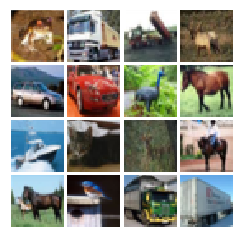

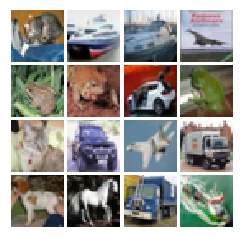

In [4]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
show_images(X_train[:16])
show_images(X_test[:16])

In [5]:
def show_images(images,gray = False):
    if(gray):
        plt.imshow(images,cmap = plt.get_cmap('gray'))
    else :
        plt.imshow(images);
    plt.show()

0
8.83209


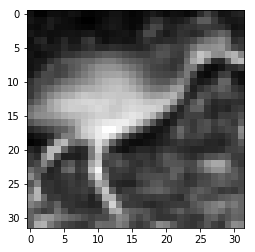

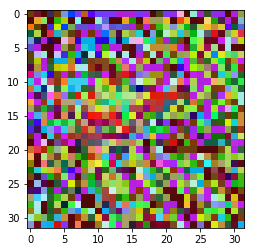

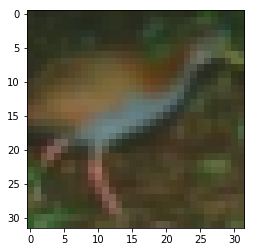

200
6.84775


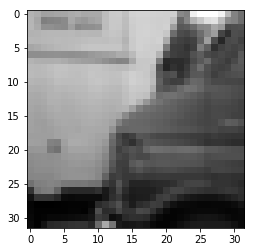

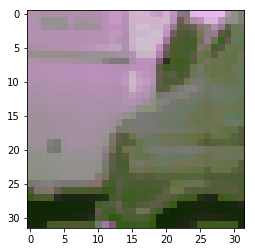

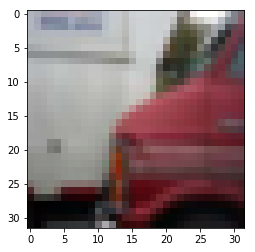

400
6.81271


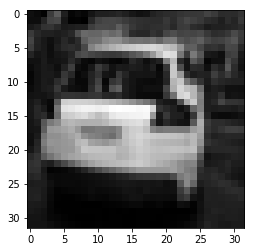

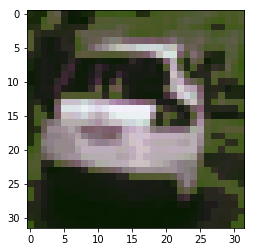

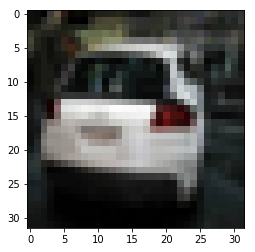

600
6.8859


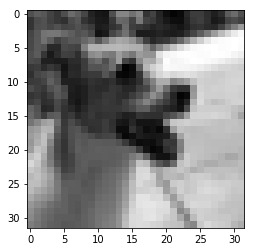

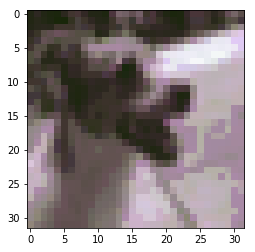

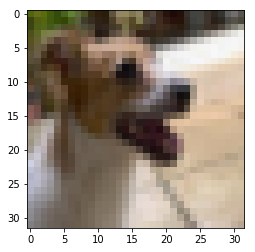

800
6.89307


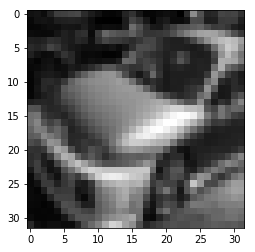

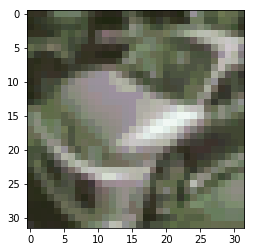

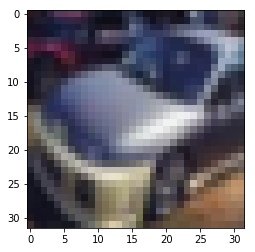

1000
6.86653


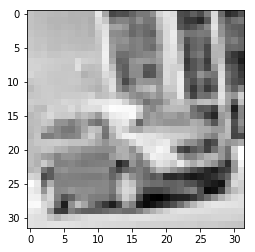

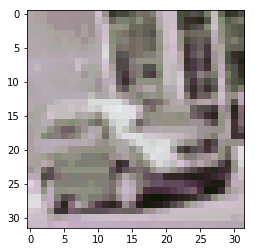

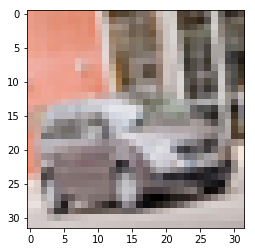

1200
6.75079


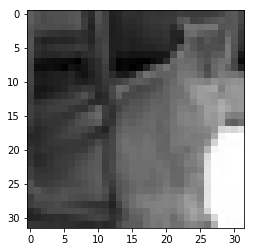

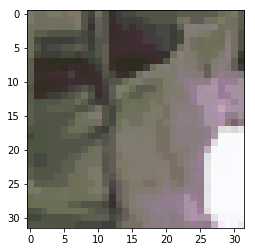

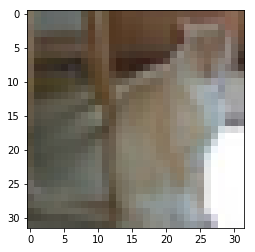

1400
7.00412


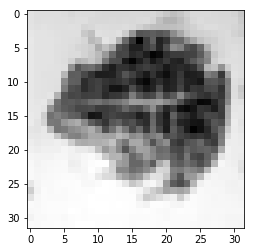

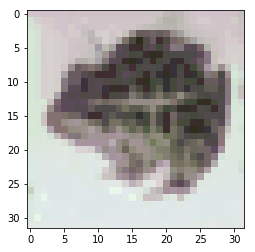

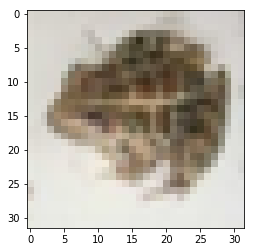

1600
7.05154


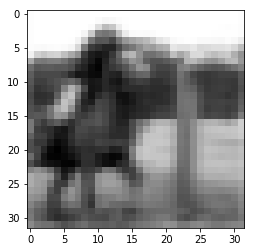

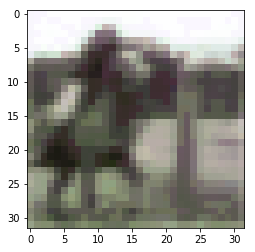

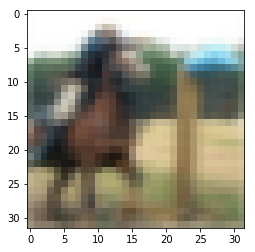

1800
6.77818


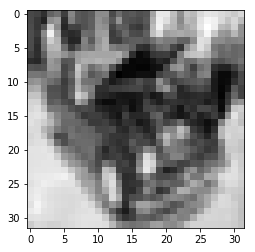

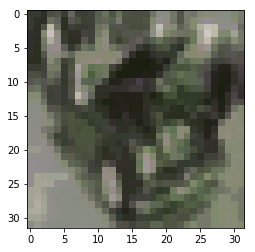

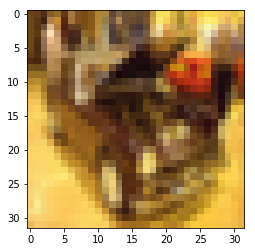

2000
6.84722


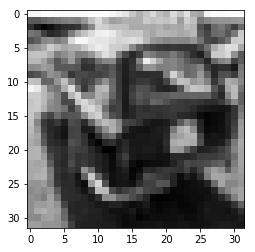

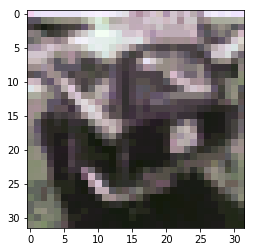

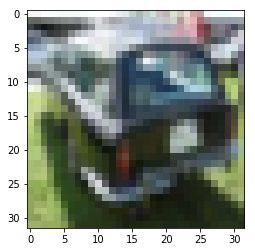

2200
6.88441


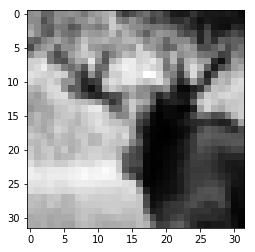

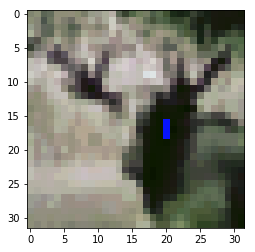

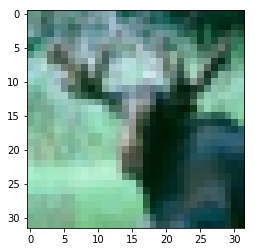

2400
6.88561


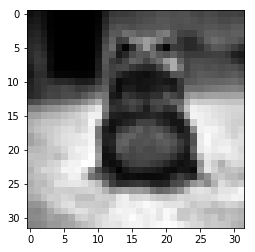

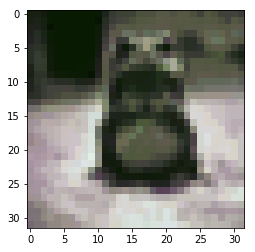

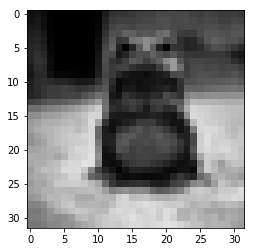

2600
6.83246


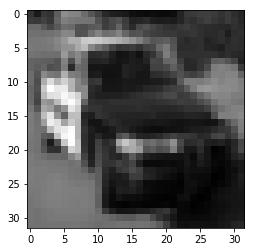

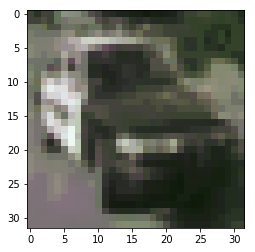

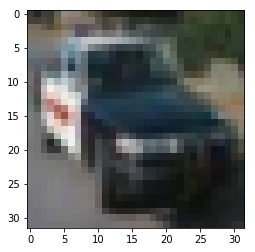

2800
6.89699


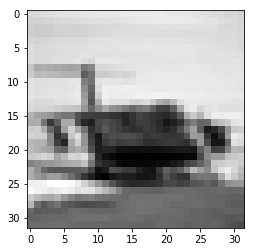

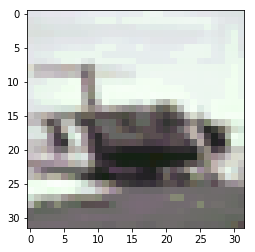

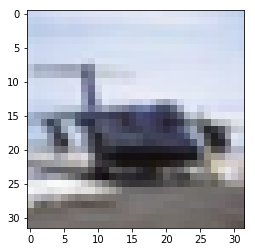

3000
6.74323


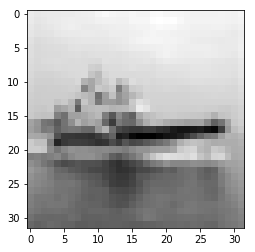

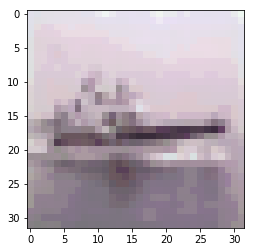

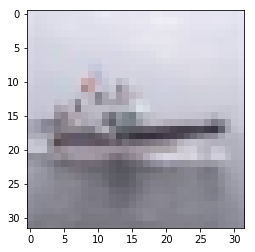

In [ ]:
from Loss_metrics import Prob_dist1, YUV2rgb2
from skimage import img_as_float

tf.reset_default_graph()

X = tf.placeholder(tf.float32 ,[None ,32,32,3])
U = tf.placeholder(tf.float32,[None,32,32,256])
V = tf.placeholder(tf.float32,[None,32,32,256])
is_training = tf.placeholder(tf.bool)

#print (Y_train.shape)

with tf.variable_scope("model") as scope:
    U_out,V_out,Y_in,UV_in = complex_pokemon_model4(X,is_training)
    reshaped_U = tf.reshape(U,shape = [-1,256])
    reshaped_U_out = tf.reshape(U_out,shape = [-1,256])
    loss_temp = tf.nn.softmax_cross_entropy_with_logits(logits = reshaped_U_out,labels = reshaped_U )
    
    reshaped_V = tf.reshape(V,shape = [-1,256])
    reshaped_V_out = tf.reshape(V_out,shape = [-1,256])
    loss_temp += tf.nn.softmax_cross_entropy_with_logits(logits = reshaped_V_out,labels = reshaped_V )
    
    weight = tf.exp(-tf.sqrt(tf.reduce_sum(tf.square(UV_in), 3)))
    
    loss_reshaped = tf.reshape(loss_temp,[-1,32,32])
    loss = tf.reduce_mean(weight*loss_reshaped)
    #loss = tf.reduce_mean(loss)
    train_step = (tf.train.AdamOptimizer(1e-3).minimize(loss))

sess = tf.Session()
saver = tf.train.Saver()
#saver.restore(sess,'../models/image_net_pok_model_trained/new_model')

import numpy.random as rnd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000):
    rand_indices = np.random.choice(50000,32,replace = False)
    samp = X_train[rand_indices]
    
    samp_float = img_as_float(samp)
    samp_YUV = samp_float.dot(yuv_converter)
    samp_rgb = samp_YUV.dot(inv_mat)
    prob_dist_u, prob_dist_v = Prob_dist1(samp_YUV)
    feed_dict = {X:samp, U:prob_dist_u, V:prob_dist_v, is_training:True}
    losses,U_o,V_o,y_in,_ = sess.run([loss,U_out,V_out,Y_in,train_step],feed_dict)
    RGB_output = YUV2rgb2(U_o, V_o, y_in)
    ### SUper chutiyaapa 0.025
     
    if(i%200==0):    
        print(i)
        saver.save(sess,'../models/class_model/mod2')
        print (losses)
        show_images(rgb2gray(samp[0]),gray = True)
        show_images(RGB_output[0])
        show_images(samp[0])

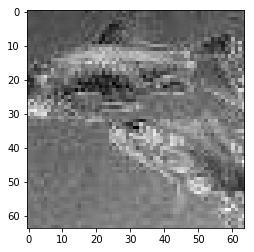

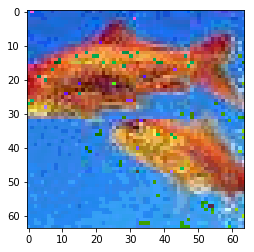

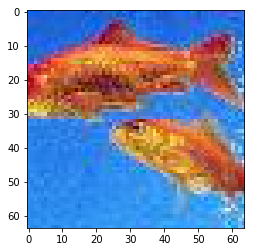

0.725904788227


In [24]:
auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_gray, [48, 64, 64, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)

show_images(rgb2gray(samp[0]),gray = True)
show_images(RGB_output[0])
show_images(samp[0])

print(np.amax(samp_float[0]-RGB_output[0]))